In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline 

In [2]:
import os
import sys

# Root directory of the project
ROOT_DIR = os.path.abspath("../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library

import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt

#from utils.utils import *
from utils.dataset import BloodCellDatasetFromDataFrame
from utils.configs import BloodCellConfig_Inference
import pandas as pd


from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.config import Config
from mrcnn.model import log
import random
import tqdm

from utils.utils import get_object_matches, get_precision_recall, calculate_ap_from_pr, convert_bbox_to_masks
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [3]:
import os
import sys
import argparse
import json
from mrcnn import utils
import mrcnn.model as modellib
import keras
import tensorflow as tf
assert(tf.__version__ == "1.15.2")
assert(keras.__version__ == "2.2.4")

In [4]:
# Define working directory
ROOT_DIR = os.path.abspath("../../")
sys.path.append(ROOT_DIR)

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "maskrcnn-master","logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "maskrcnn-master", "mask_rcnn_coco.h5")


# Directory of images to run detection on
IMAGE_DIR_A = os.path.join(ROOT_DIR, "BCCD_Dataset/BCCD")

# Directory of images to run detection on
IMAGE_DIR_B = os.path.join(ROOT_DIR, "segmentation_WBC")



IMAGE_COLLECTION_PATH = r'../blood_cell_dataset.pkl'


# 1. Fetch metadata, prepare dataset for evaluation

In [5]:
if not os.path.exists(IMAGE_COLLECTION_PATH):
    raise Exception(f"IC_PATH @ {IMAGE_COLLECTION_PATH} not found.")
else:
    dataset = pd.read_pickle(IMAGE_COLLECTION_PATH)
    train_samples_A = dataset[(dataset["role"] == "train")&(dataset["origin"] == "A")]
    train_samples_B = dataset[(dataset["role"] == "train")&(dataset["origin"] == "B")]
    val_samples = dataset[dataset["role"] == "val"]

print(f"Number of samples in training set A: {len(train_samples_A)}")
print(f"Number of samples in training set B: {len(train_samples_B)}")
print(f"Number of samples in valid set: {len(val_samples)}")

Number of samples in training set A: 295
Number of samples in training set B: 100
Number of samples in valid set: 69


# 2. Reload trained model

In [6]:
dataset_val = BloodCellDatasetFromDataFrame(val_samples, directory_path_A = IMAGE_DIR_A)
dataset_val.load_kernel()

In [7]:
config = BloodCellConfig_Inference()
config.IMAGE_RESIZE_MODE = "pad64"
config.IMAGE_SHAPE = [640,640,3]

In [8]:
MODEL_BRANCH = "bloodcell20201216T1102"
CHECKPOINT_EPOCH = 100
# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference",
                          config=config,
                          model_dir=MODEL_DIR)
model_path = os.path.join(MODEL_DIR, MODEL_BRANCH,
                          f"mask_rcnn_bloodcell_{CHECKPOINT_EPOCH:04d}.h5")
model.load_weights(model_path, by_name=True)







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.






Re-starting from epoch 100


# 3.Evaluate single sample

## 3.1. Visualization

original_image           shape: (1024, 1408, 3)       min:    0.00000  max:  247.00000  uint8
image_meta               shape: (21,)                 min:    0.00000  max: 1408.00000  float64
gt_class_id              shape: (14,)                 min:    1.00000  max:    7.00000  int32
gt_bbox                  shape: (14, 4)               min:   23.00000  max: 1350.00000  int32
gt_mask                  shape: (1024, 1408, 14)      min:    0.00000  max:  127.00000  uint8


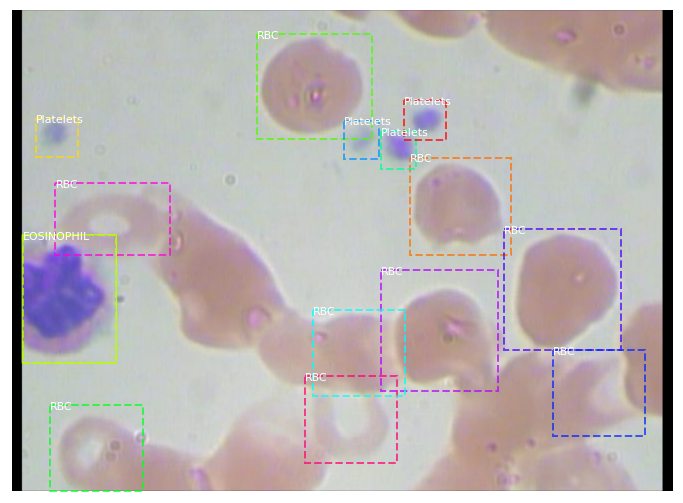

In [9]:
dataset_inference = dataset_val
# Test on a random image
image_id = random.choice(dataset_inference.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_inference, config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_inference.class_names_preset, figsize=(12, 12))

Processing 1 images
image                    shape: (1024, 1408, 3)       min:    0.00000  max:  247.00000  uint8
molded_images            shape: (1, 1024, 1408, 3)    min: -123.70000  max:  143.10000  float64
image_metas              shape: (1, 21)               min:    0.00000  max: 1408.00000  int64
anchors                  shape: (1, 360096, 4)        min:   -0.08847  max:    1.02591  float32


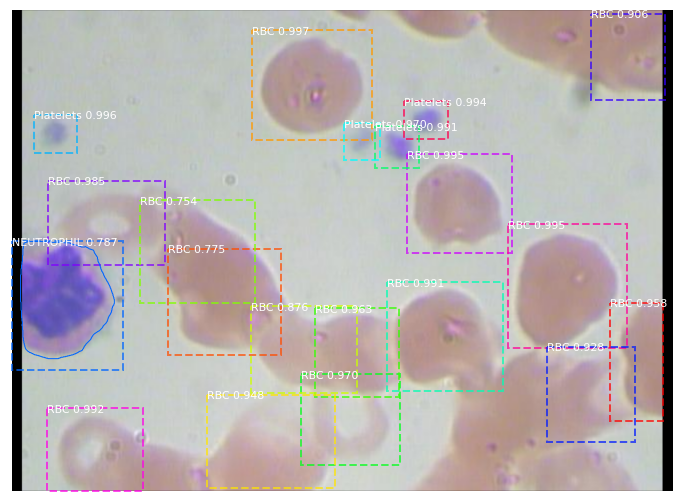

In [10]:
results = model.detect([original_image], verbose=1)
# r['scores']
r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_inference.class_names_preset, r['scores'], figsize=(12, 12), show_mask=False)

## 3.2. Single Sample AP50/AP75

In [11]:
gt_mask_bbox = convert_bbox_to_masks(gt_bbox, gt_mask.shape[:-1])
pred_mask_bbox = convert_bbox_to_masks(r["rois"], r['masks'].shape[:-1])
    
AP50, precisions50, recalls50, overlaps50 =\
    utils.compute_ap(gt_bbox, gt_class_id, gt_mask_bbox,
                     r["rois"], r["class_ids"], r["scores"], pred_mask_bbox, 0.5)
AP75, precisions75, recalls75, overlaps75 =\
    utils.compute_ap(gt_bbox, gt_class_id, gt_mask_bbox,
                     r["rois"], r["class_ids"], r["scores"], pred_mask_bbox, 0.75)

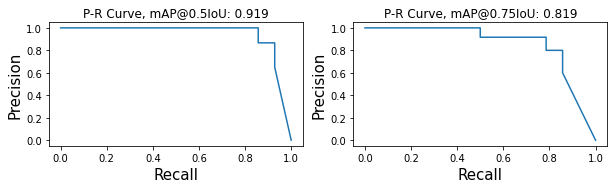

In [12]:
fig = plt.figure(figsize=(10,5))

plt.subplot(221)
plt.plot(recalls50, precisions50)
plt.xlabel("Recall", fontsize=15)
plt.ylabel("Precision", fontsize=15)
plt.title(f"P-R Curve, mAP@0.5IoU: {round(AP50,3)}")

plt.subplot(222)
plt.plot(recalls75, precisions75)
plt.xlabel("Recall", fontsize=15)
plt.ylabel("Precision", fontsize=15)
plt.title(f"P-R Curve, mAP@0.75IoU: {round(AP75,3)}")
plt.show()

## 3.3. Single Sample Match Matrix

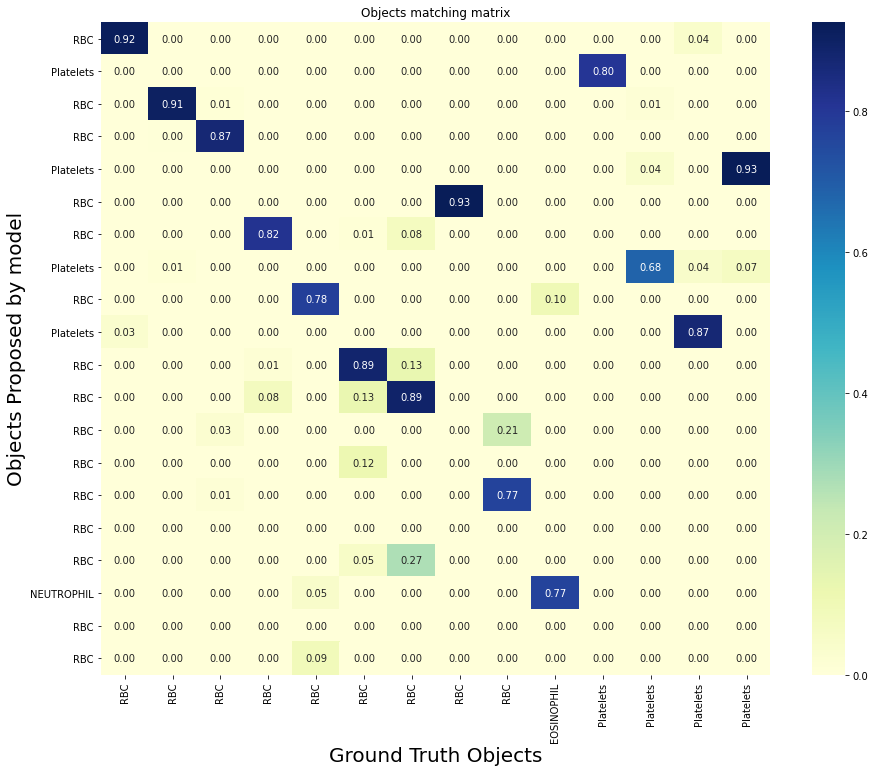

In [13]:
gt_class_names = [dataset_inference.class_names_preset[i] for i in gt_class_id]
pred_class_names = [dataset_inference.class_names_preset[i] for i in r["class_ids"]]

df_mm = pd.DataFrame(overlaps50, index=pred_class_names,
                 columns=gt_class_names)
plt.figure(figsize=(15, 12))
sn.heatmap(df_mm, annot=True, cmap="YlGnBu", fmt="2.2f")
plt.xlabel("Ground Truth Objects", fontsize=20)
plt.ylabel("Objects Proposed by model", fontsize=20)
plt.title("Objects matching matrix")
plt.show()

# 4. Evaluate dataset

## 4.1. P-R Curve

In [14]:
dataset_inference = dataset_val
IoU = 0.75

object_matches = []

for image_id in tqdm.tqdm(dataset_inference.image_ids):
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_inference, config,
                               image_id, use_mini_mask=False)
    results = model.detect([original_image], verbose=0)
    r = results[0]
    # Use bbox rather than mask to calculate overlap/match
    gt_mask_bbox = convert_bbox_to_masks(gt_bbox, gt_mask.shape[:-1])
    pred_mask_bbox = convert_bbox_to_masks(r["rois"], r['masks'].shape[:-1])
    gt_matches, pred_matches, overlaps = utils.compute_matches(
        gt_bbox, gt_class_id, gt_mask_bbox, r["rois"],
        r["class_ids"], r["scores"], pred_mask_bbox, IoU)

    object_matches += get_object_matches(r, pred_matches, gt_matches, gt_class_id, image_id, overlaps)

100%|██████████| 69/69 [01:26<00:00,  1.25s/it]


In [15]:
load_from_legacy_result = False
if load_from_legacy_result:
    df = pd.read_pickle(f'./evaluation_results_val_{CHECKPOINT_EPOCH}.pkl')
else:
    df = pd.DataFrame(object_matches)
    df.to_pickle(f'./evaluation_results_val_{CHECKPOINT_EPOCH}.pkl')

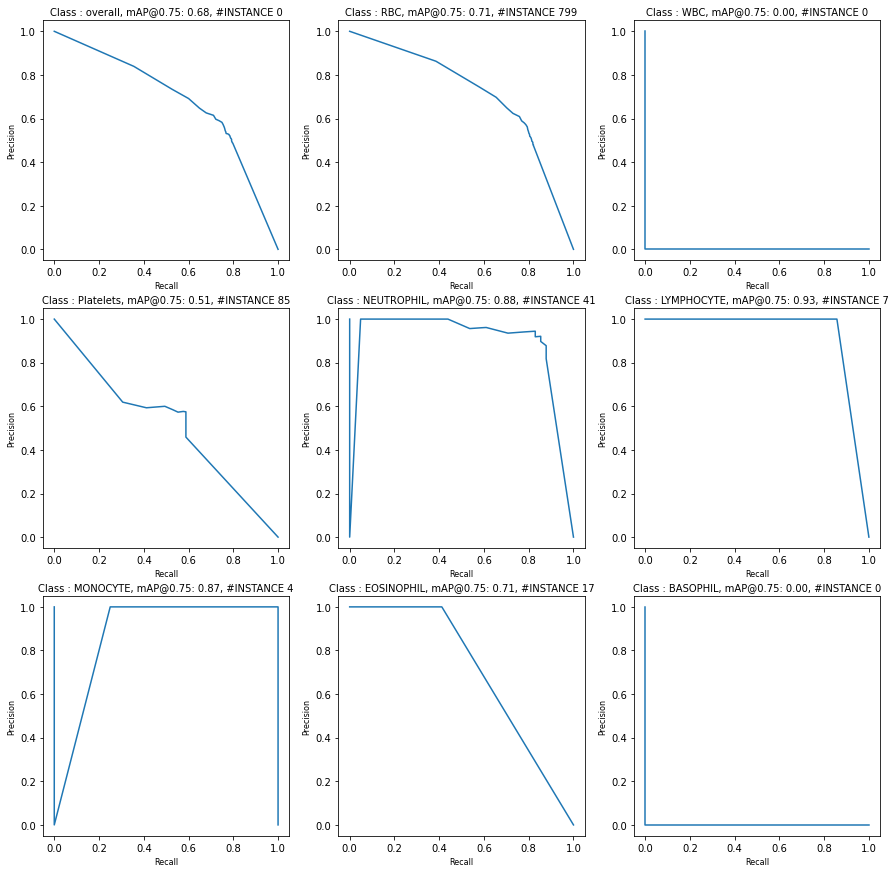

In [16]:
 _, axs = plt.subplots(3, 3, figsize=(15, 15))
for class_id in range(len(dataset_inference.class_names_preset)):
    if class_id == 0:
        df_class = df
        class_name = "overall"
    else:
        df_class = df[(df.pred_class == class_id)|(df.gt_class == class_id)]
        class_name = dataset_inference.class_names_preset[class_id]

    precisions, recalls = get_precision_recall(df_class)
    mAP = calculate_ap_from_pr(precisions, recalls)
    row = int(np.floor(class_id / 3))
    col = class_id % 3
    axs[row, col].plot(recalls, precisions)
    axs[row, col].set_xlabel("Recall", fontsize=8)
    axs[row, col].set_ylabel("Precision", fontsize=8)
    axs[row, col].set_title(f"Class : {class_name}, mAP@0.75: {mAP:.2f}, #INSTANCE {np.sum(df.gt_class == class_id)}", fontsize=10)

## 4.2. WBC Classification

In [17]:
dataset_inference = dataset_val

wbc_classifications = []

for image_id in tqdm.tqdm(dataset_inference.image_ids):
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_inference, config,
                               image_id, use_mini_mask=False)
    results = model.detect([original_image], verbose=0)
    r = results[0]
    
    info = dataset_inference.image_info[image_id]
    
    gt_class = info['sub_class_label'][0]
    
    gt_class_cvts = dataset_inference.class_names_preset[[l for l in gt_class_id if l > 3]]
    pred_classes = dataset_inference.class_names_preset[[l for l in r["class_ids"] if l > 3]]
    
    assert gt_class == gt_class_cvts[0]
    
    if len(pred_classes) > 1:
        pred_classes = "MULTI"
    elif len(pred_classes) < 1:
        pred_classes = "MISS"
    else:
        pred_classes = pred_classes[0]
    
    wbc_classifications.append({"image_id":image_id, "gt_wbc_class": gt_class, "pred_wbc_class": pred_classes})

100%|██████████| 69/69 [01:02<00:00,  1.11it/s]


In [18]:
wbc_classifications

[{'image_id': 0, 'gt_wbc_class': 'LYMPHOCYTE', 'pred_wbc_class': 'LYMPHOCYTE'},
 {'image_id': 1, 'gt_wbc_class': 'NEUTROPHIL', 'pred_wbc_class': 'NEUTROPHIL'},
 {'image_id': 2, 'gt_wbc_class': 'EOSINOPHIL', 'pred_wbc_class': 'NEUTROPHIL'},
 {'image_id': 3, 'gt_wbc_class': 'NEUTROPHIL', 'pred_wbc_class': 'NEUTROPHIL'},
 {'image_id': 4, 'gt_wbc_class': 'NEUTROPHIL', 'pred_wbc_class': 'NEUTROPHIL'},
 {'image_id': 5, 'gt_wbc_class': 'EOSINOPHIL', 'pred_wbc_class': 'EOSINOPHIL'},
 {'image_id': 6, 'gt_wbc_class': 'NEUTROPHIL', 'pred_wbc_class': 'NEUTROPHIL'},
 {'image_id': 7, 'gt_wbc_class': 'NEUTROPHIL', 'pred_wbc_class': 'NEUTROPHIL'},
 {'image_id': 8, 'gt_wbc_class': 'NEUTROPHIL', 'pred_wbc_class': 'NEUTROPHIL'},
 {'image_id': 9, 'gt_wbc_class': 'NEUTROPHIL', 'pred_wbc_class': 'NEUTROPHIL'},
 {'image_id': 10,
  'gt_wbc_class': 'EOSINOPHIL',
  'pred_wbc_class': 'EOSINOPHIL'},
 {'image_id': 11,
  'gt_wbc_class': 'NEUTROPHIL',
  'pred_wbc_class': 'NEUTROPHIL'},
 {'image_id': 12,
  'gt_wbc_cl

<AxesSubplot:>

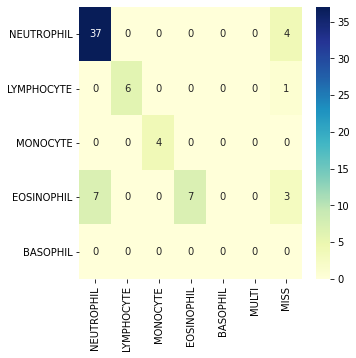

In [19]:
gt_classes = list(dataset_inference.class_names_preset)[4:]
pred_classes = list(dataset_inference.class_names_preset)[4:] + ["MULTI", "MISS"]
cm = np.zeros((len(gt_classes), len(pred_classes)))
for l in wbc_classifications:
    GT = gt_classes.index(l["gt_wbc_class"])
    PRED = pred_classes.index(l["pred_wbc_class"])
    cm[GT,PRED]+=1

import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(cm.astype(np.int), index = gt_classes,
                 columns= pred_classes)
plt.figure(figsize = (5,5))
sn.heatmap(df_cm, annot=True, cmap="YlGnBu", fmt="d")


original_image           shape: (1024, 1408, 3)       min:    0.00000  max:  247.00000  uint8
image_meta               shape: (21,)                 min:    0.00000  max: 1408.00000  float64
gt_class_id              shape: (14,)                 min:    1.00000  max:    7.00000  int32
gt_bbox                  shape: (14, 4)               min:   23.00000  max: 1350.00000  int32
gt_mask                  shape: (1024, 1408, 14)      min:    0.00000  max:  127.00000  uint8


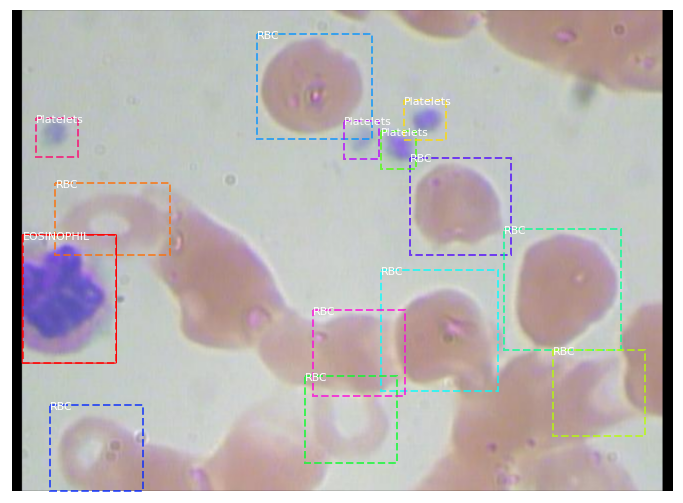

In [28]:
image_id = 57
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_inference, config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_inference.class_names_preset, figsize=(12, 12))

Processing 1 images
image                    shape: (1024, 1408, 3)       min:    0.00000  max:  247.00000  uint8
molded_images            shape: (1, 1024, 1408, 3)    min: -123.70000  max:  143.10000  float64
image_metas              shape: (1, 21)               min:    0.00000  max: 1408.00000  int64
anchors                  shape: (1, 360096, 4)        min:   -0.08847  max:    1.02591  float32


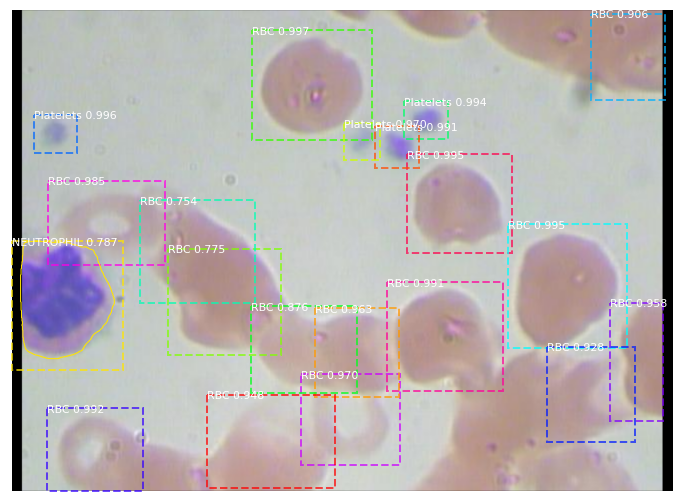

In [29]:
results = model.detect([original_image], verbose=1)
# r['scores']
r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_inference.class_names_preset, r['scores'], figsize=(12, 12), show_mask=False)